<a href="https://colab.research.google.com/github/graphlit/graphlit-evals/blob/main/tonic-validate/Tonic_Validate_LlamaIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tonic_validate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 812.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00


In [2]:
%pip install --upgrade llama-index-postprocessor-cohere-rerank

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.5 MB/s eta 0:00:00


In [3]:
!pip install --upgrade llama-index

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 23.2 MB/s eta 0:00:00


In [4]:
import os
from typing import Optional
from tonic_validate import ValidateScorer, Benchmark, BenchmarkItem, LLMResponse, BenchmarkItem, Run
from tonic_validate.metrics import AnswerSimilarityMetric
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import os
import time
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import userdata

In [5]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# configure shared, writable folder containing sample data
tonic_validate_directory = "/content/drive/MyDrive/Colab Notebooks/Tonic Validate"

Mounted at /content/drive


Initialize LlamaIndex

In [6]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Settings
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.embeddings.openai import OpenAIEmbedding, OpenAIEmbeddingModelType
from llama_index.llms.openai import OpenAI
from llama_index.postprocessor.cohere_rerank import CohereRerank

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['COHERE_API_KEY'] = userdata.get('COHERE_API_KEY')

Settings.llm = OpenAI(temperature=0.1, model="gpt-4-turbo")
Settings.embed_model = OpenAIEmbedding(model=OpenAIEmbeddingModelType.TEXT_EMBED_ADA_002)

Load benchmark questions & answers

In [7]:
with open(f"{tonic_validate_directory}/Sample Data/qa_pairs.json", "r") as f:
    qa_pairs = json.load(f)

# for testing
qa_pairs = qa_pairs

benchmark = Benchmark(
    questions=[x["question"] for x in qa_pairs],
    answers=[x["answer"] for x in qa_pairs]
)

def run_to_dataframe(run: Run) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "reference_question": [x.reference_question for x in run.run_data],
            "reference_answer": [x.reference_answer for x in run.run_data],
            "llm_answer": [x.llm_answer for x in run.run_data],
            "llm_context": [json.dumps(x.llm_context) for x in run.run_data],
            "answer_similarity": [x.scores["answer_similarity"] for x in run.run_data]
        }
    )

Define LlamaIndex helper functions

In [8]:
def upload_essays():
    directory = f"{tonic_validate_directory}/Sample Data/paul_graham_essays"

    start_time = time.time()

    documents = SimpleDirectoryReader(directory).load_data()

    index = VectorStoreIndex.from_documents(documents, show_progress=True)

    retriever = VectorIndexRetriever(
        index=index,
        similarity_top_k=10,
    )

    postprocessor = CohereRerank(
        top_n=2, model="rerank-english-v3.0", api_key=os.environ['COHERE_API_KEY']
    )

    query_engine = RetrieverQueryEngine(
       retriever=retriever,
       node_postprocessors=[postprocessor]
    )

    duration = time.time() - start_time

    current_time = datetime.now()
    formatted_time = current_time.strftime("%H:%M:%S")

    print(f"Uploading essays took {duration:.2f} seconds. Finished at {formatted_time} UTC.")

    return query_engine

Define LlamaIndex RAG function

In [9]:
def get_llamaindex_rag_response(benchmarkItem: BenchmarkItem, query_engine):
    prompt = benchmarkItem.question

    response = query_engine.query(prompt)

    return response.response

Initialize LlamaIndex test

In [10]:
query_engine = upload_essays()

Parsing nodes:   0%|          | 0/212 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/866 [00:00<?, ?it/s]

Uploading essays took 26.23 seconds. Finished at 07:00:51 UTC.


Validate LlamaIndex response

In [11]:
benchmark_item = BenchmarkItem(
    question="What key components are necessary to create a technology hub according to Paul Graham?",
    answer=""
)

print(get_llamaindex_rag_response(benchmark_item, query_engine))

According to Paul Graham, the key components necessary to create a technology hub are the presence of both rich people and nerds. Rich people, particularly those with experience in the technology business, are crucial as they provide the necessary investment and guidance for startups. Nerds, or technically skilled individuals, are essential for the innovation and development of new technologies. Additionally, an environment where startups are seen as a desirable and normal activity, along with the opportunity for chance meetings with helpful individuals, significantly contributes to the success and proliferation of startups within a technology hub.


Perform LlamaIndex test and score run

In [12]:
import asyncio

async def run_test():
    with ThreadPoolExecutor() as executor:
        tasks = []
        for item in benchmark.items:
            task = asyncio.get_event_loop().run_in_executor(executor, get_llamaindex_rag_response, item, query_engine)
            tasks.append(task)

        return await asyncio.gather(*tasks)

raw_llamaindex_responses = await run_test()

In [13]:
llamaindex_responses = [
    LLMResponse(
        llm_answer=r, llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_llamaindex_responses, benchmark.items)
]

In [14]:
scorer = ValidateScorer(model_evaluator="gpt-4-turbo", metrics=[AnswerSimilarityMetric()])
llamaindex_run = scorer.score_run(llamaindex_responses, parallelism=5)

Scoring responses:   2%|▏         | 1/55 [00:00<00:29,  1.83it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:  11%|█         | 6/55 [00:01<00:09,  4.98it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:  24%|██▎       | 13/55 [00:02<00:06,  6.24it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:  29%|██▉       | 16/55 [00:03<00:08,  4.57it/s]INFO:httpx

In [15]:
llamaindex_run_df = run_to_dataframe(llamaindex_run)
llamaindex_run_df.to_csv(f"{tonic_validate_directory}/llamaindex_run.csv", index=False)

Visualize LlamaIndex test

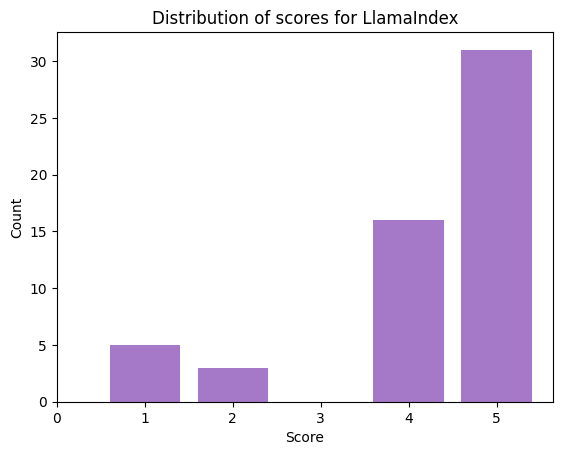

In [16]:
llamaindex_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in llamaindex_run.run_data])
category_counts = llamaindex_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for LlamaIndex')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()